In [117]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

### Data quality asessment and data cleaning

In [118]:
data = pd.read_csv("sp500_stocks.csv", parse_dates=["Date"])

In [119]:

colunas = [col for col in data.columns if col not in ["Symbol", "Date"]]

empresas_validas = data.groupby("Symbol").filter(
    lambda x: not x[colunas].isna().all().all()
)

#empresas_validas.to_csv("sp500_filtered.csv", index=False)



In [120]:
data_filtered = pd.read_csv("sp500_filtered.csv")

In [121]:
empresas_dataframes = {}

for symbol in data_filtered["Symbol"].unique():
    df_empresa = data_filtered[data_filtered["Symbol"] == symbol]
    empresas_dataframes[symbol] = df_empresa

# Acessar o dataframe de uma empresa específica, como AAPL
df_aapl = empresas_dataframes["ZBRA"]
print(df_aapl.head())

              Date Symbol  Adj Close      Close       High        Low  \
626918  2010-01-04   ZBRA  28.670000  28.670000  28.700001  28.070000   
626919  2010-01-05   ZBRA  28.620001  28.620001  29.370001  28.540001   
626920  2010-01-06   ZBRA  28.400000  28.400000  28.490000  27.320000   
626921  2010-01-07   ZBRA  27.690001  27.690001  28.299999  27.610001   
626922  2010-01-08   ZBRA  27.600000  27.600000  27.610001  27.280001   

             Open    Volume  
626918  28.469999  168800.0  
626919  28.549999  168800.0  
626920  27.410000  385300.0  
626921  28.230000  183600.0  
626922  27.580000  266500.0  


### Data pre-processing

Lagged Features

	•	Previous days values to predict future prices.

 Moving Averages

	•	Smooth data and trends over a window 

Volatility Indicators

	•	Standard deviation or percentage changes

Rate of Change (Momentum)

	•	Momentum of price movements

Relative Strength Index (RSI)

	•	Overbought or oversold conditions

In [122]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_dataframe(df):
    # Garantir que estamos trabalhando com uma cópia do DataFrame
    df = df.copy()
    
    # Criar colunas de lags
    for lag in [1, 3, 7]:
        df.loc[:, f"Close_lag_{lag}"] = df["Close"].shift(lag)
    
    # Médias móveis e volatilidade
    df.loc[:, "MA_5"] = df["Close"].rolling(window=5).mean()
    df.loc[:, "MA_10"] = df["Close"].rolling(window=10).mean()
    df.loc[:, "Volatility_5"] = df["Close"].rolling(window=5).std()

    # Rate of Change (ROC)
    df.loc[:, "ROC_5"] = df["Close"].pct_change(periods=5)
    
    # Relative Strength Index (RSI)
    def calculate_rsi(data, window=14):
        delta = data["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df.loc[:, "RSI"] = calculate_rsi(df)
    
    # Criar coluna de Target
    df.loc[:, "Target"] = df["Close"].shift(-1)
    
    # Normalização
    scaler = MinMaxScaler()
    numeric_columns = [
        "Open", "High", "Low", "Close", "Volume",
        "Close_lag_1", "Close_lag_3", "Close_lag_7",
        "MA_5", "MA_10", "Volatility_5", "ROC_5", "RSI", "Target"
    ]
    
    # Aplicar escalonamento apenas nas colunas numéricas
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    # Preenchimento de valores ausentes
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    
    return df

In [123]:
empresas_dataframes = {
    symbol: preprocess_dataframe(df)
    for symbol, df in empresas_dataframes.items()
}

### Exploratory Data Analysis

In [124]:
# Assuming 'empresas_dataframes' is a dictionary of dataframes
combined_df = pd.concat(
    [df.assign(Symbol=symbol) for symbol, df in empresas_dataframes.items()],
    ignore_index=True
)
print(combined_df.shape)  # Check the size of the combined dataframe

(630672, 17)


In [125]:
# General statistics for the entire dataset (across all companies)
print(combined_df.describe())

           Adj Close          Close           High            Low  \
count  630672.000000  630672.000000  630672.000000  630672.000000   
mean       98.398637       0.340963       0.342961       0.342324   
std       203.781150       0.265727       0.270198       0.265366   
min         1.030000       0.000000       0.000000       0.000000   
25%        25.751807       0.099855       0.099712       0.101049   
50%        48.711182       0.292600       0.290084       0.293411   
75%        98.205870       0.547345       0.550602       0.548512   
max      5224.279785       1.000000       1.000000       1.000000   

                Open         Volume    Close_lag_1    Close_lag_3  \
count  630672.000000  630672.000000  630672.000000  630672.000000   
mean        0.342158       0.085416       0.340809       0.340607   
std         0.266397       0.134862       0.265672       0.265608   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.101404       0.0246

In [126]:
# Check missing data across all companies
print(combined_df.isnull().sum())

Date            0
Symbol          0
Adj Close       0
Close           0
High            0
Low             0
Open            0
Volume          0
Close_lag_1     0
Close_lag_3     0
Close_lag_7     0
MA_5            0
MA_10           0
Volatility_5    0
ROC_5           0
RSI             0
Target          0
dtype: int64


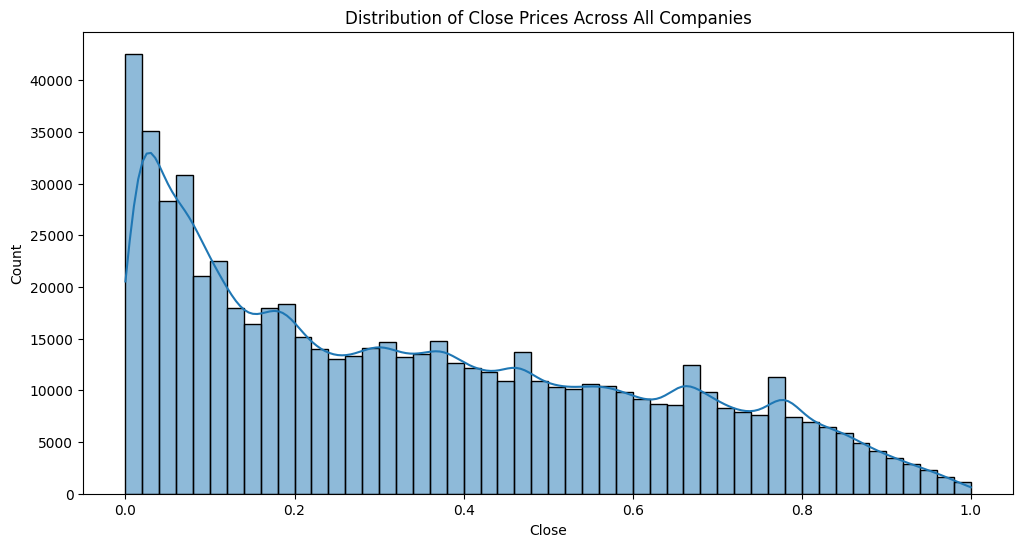

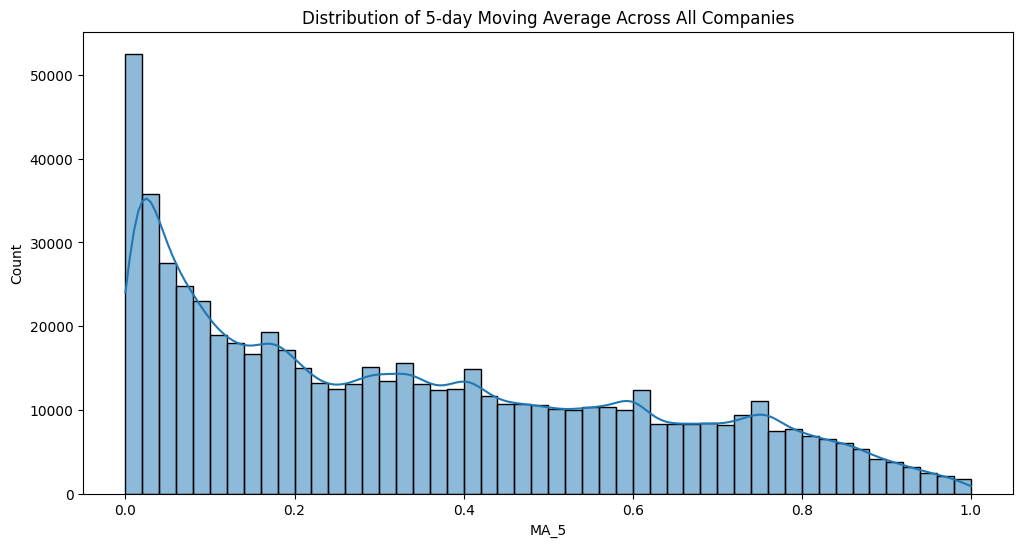

In [127]:
# Distribution of 'Close' prices for all companies
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['Close'], kde=True, bins=50)
plt.title('Distribution of Close Prices Across All Companies')
plt.show()

# Distribution of moving averages across all companies
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['MA_5'], kde=True, bins=50)
plt.title('Distribution of 5-day Moving Average Across All Companies')
plt.show()

# You can add more indicators in the same way

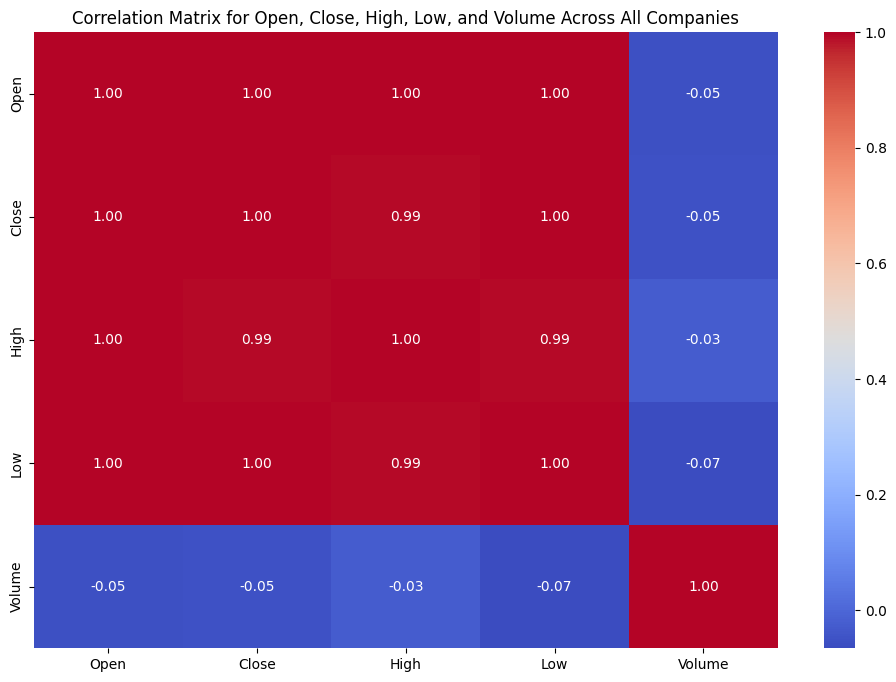

In [128]:
# Select only the relevant columns for correlation
relevant_columns = ['Open', 'Close', 'High', 'Low', 'Volume']
relevant_df = combined_df[relevant_columns]

# Calculate the correlation matrix
corr_matrix = relevant_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix for Open, Close, High, Low, and Volume Across All Companies')
plt.show()

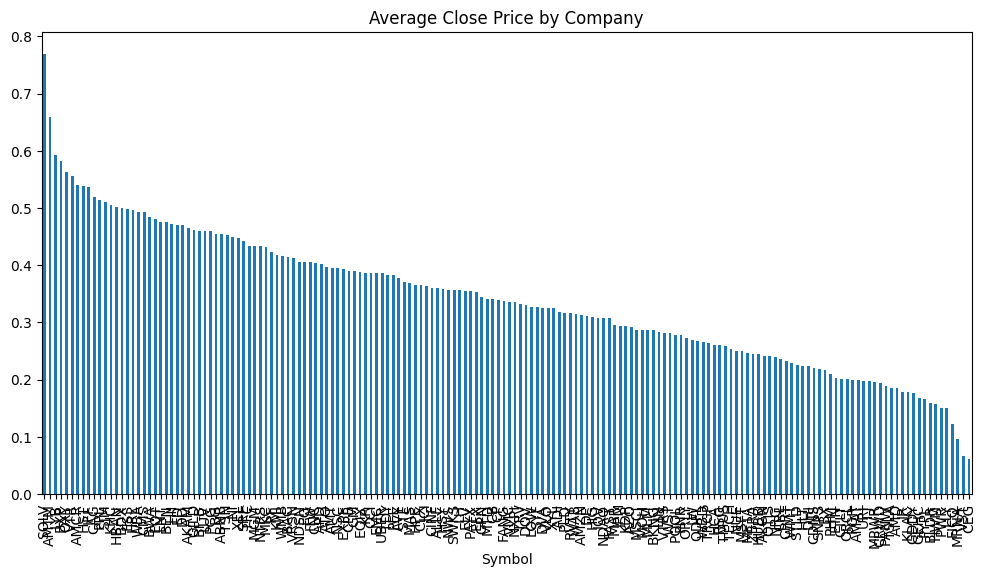

In [129]:
# Mean Close Price by Company
plt.figure(figsize=(12, 6))
avg_close_by_company = combined_df.groupby('Symbol')['Close'].mean().sort_values(ascending=False)
avg_close_by_company.plot(kind='bar')
plt.title('Average Close Price by Company')
plt.show()

# You can also compare other indicators, such as moving averages or volatility

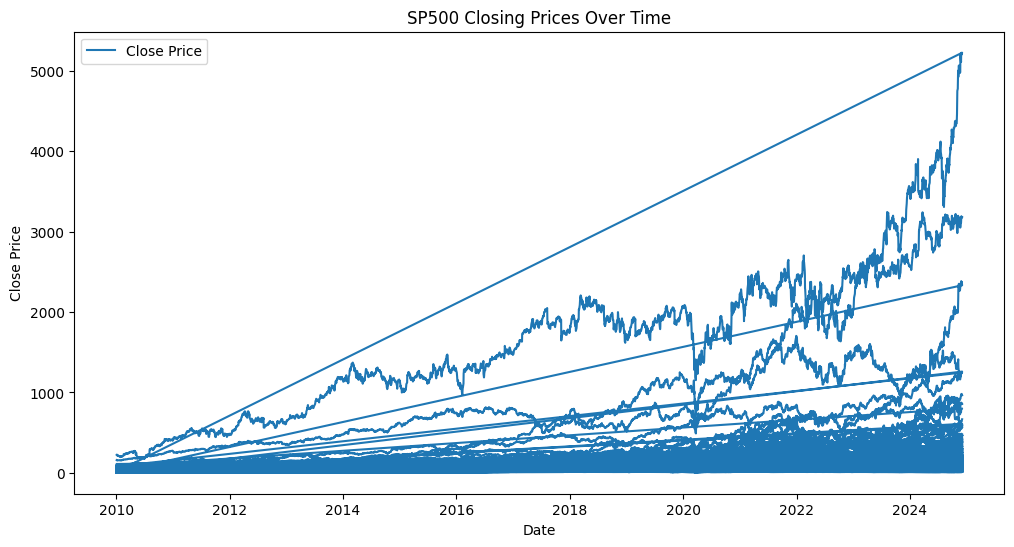

In [130]:

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('SP500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

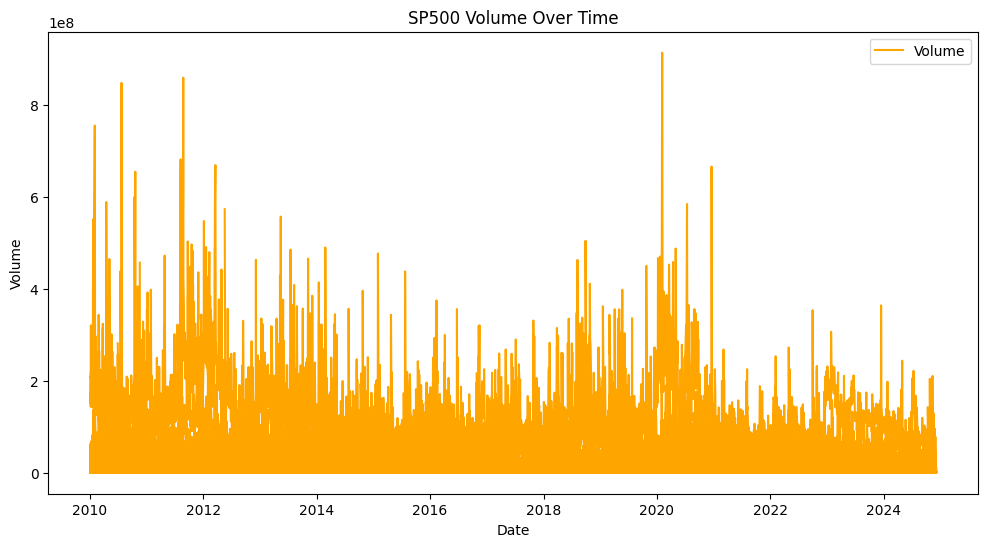

In [131]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volume'], color='orange', label='Volume')
plt.title('SP500 Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

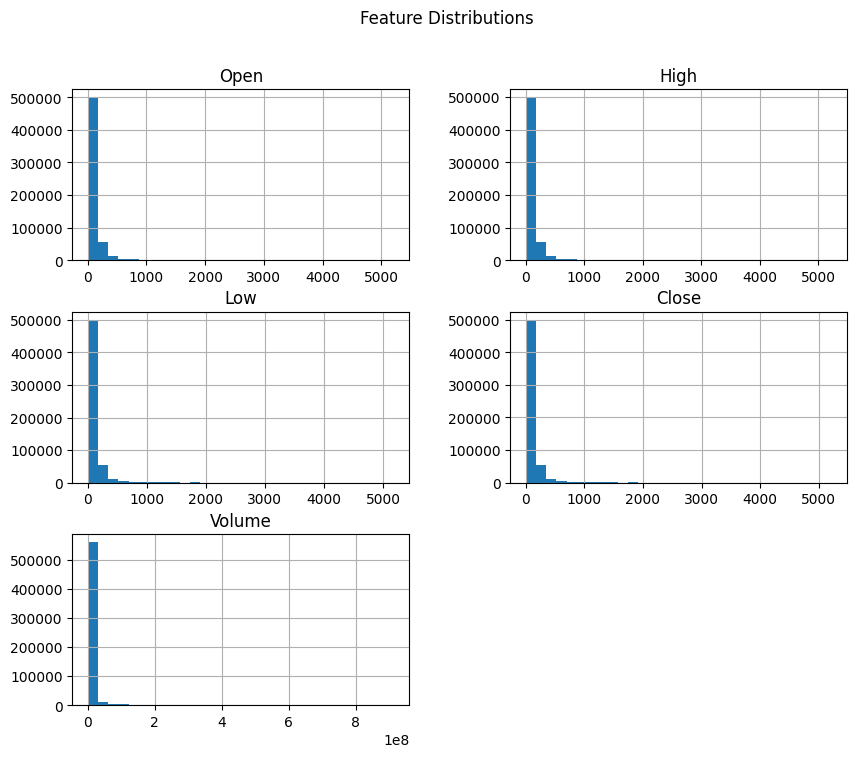

In [132]:
data[['Open', 'High', 'Low', 'Close', 'Volume']].hist(figsize=(10, 8), bins=30)
plt.suptitle('Feature Distributions')
plt.show()

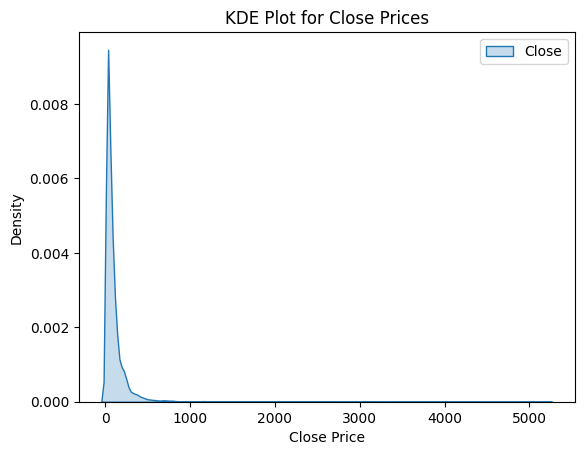

In [133]:
sns.kdeplot(data['Close'], label='Close', fill=True)
plt.title('KDE Plot for Close Prices')
plt.xlabel('Close Price')
plt.legend()
plt.show()

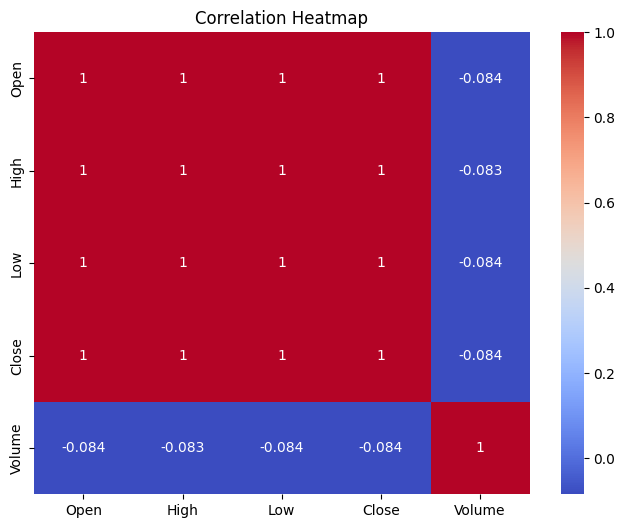

In [134]:
corr_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [135]:
def data_split(data):
    train_data = data[(data['Date'] >= '2010-01-01') & (data['Date'] < '2022-07-01')]
    val_data = data[(data['Date'] >= '2022-07-01') & (data['Date'] < '2024-01-01')]
    test_data = data[data['Date'] >= '2024-01-01']

    X_train = train_data.drop(['Date', 'Symbol', 'Target'], axis=1)
    y_train = train_data['Target']
    X_test = test_data.drop(['Date', 'Symbol', 'Target'], axis=1)
    y_test = test_data['Target']
    X_val = val_data.drop(['Date', 'Symbol', 'Target'], axis=1)
    y_val = val_data['Target']

    return X_train, y_train, X_test, y_test, X_val, y_val 

In [ ]:
def calculate_mase(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    absolute_error = np.abs(y_true - y_pred)
    
    naive_error = np.abs(np.diff(y_true))

    mean_naive_error = np.mean(naive_error)
    
    if mean_naive_error == 0:
        return float('nan')  

    mase = np.mean(absolute_error[1:] / mean_naive_error)  
    return mase


In [141]:
def evaluate_models_for_all_companies(empresa_df):
    results = []

    for empresa_name, empresa_df in empresas_dataframes.items():
        print(f"Avaliando {empresa_name}...")
        X_train, y_train, X_test, y_test, X_val, y_val = data_split(empresa_df)

        company_results = {'Empresa': empresa_name}

        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        y_val_pred = rf_model.predict(X_val)
        rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae_val_rf = mean_absolute_error(y_val, y_val_pred)
        mape_val_rf = calculate_mase(y_val, y_val_pred)

        y_test_pred = rf_model.predict(X_test)
        rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred))
        mae_test_rf = mean_absolute_error(y_test, y_test_pred)
        mape_test_rf = calculate_mase(y_test, y_test_pred)

        company_results.update({
            'RF_Val_RMSE': rmse_val_rf, 'RF_Val_MAE': mae_val_rf, 'RF_Val_MASE': mape_val_rf,
            'RF_Test_RMSE': rmse_test_rf, 'RF_Test_MAE': mae_test_rf, 'RF_Test_MASE': mape_test_rf
        })

        xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        xgb_model.fit(X_train, y_train)
        y_val_pred_xgb = xgb_model.predict(X_val)
        rmse_val_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
        mae_val_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
        mape_val_xgb = calculate_mase(y_val, y_val_pred_xgb)

        y_test_pred_xgb = xgb_model.predict(X_test)
        rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
        mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
        mape_test_xgb = calculate_mase(y_test, y_test_pred_xgb)

        company_results.update({
            'XGB_Val_RMSE': rmse_val_xgb, 'XGB_Val_MAE': mae_val_xgb, 'XGB_Val_MASE': mape_val_xgb,
            'XGB_Test_RMSE': rmse_test_xgb, 'XGB_Test_MAE': mae_test_xgb, 'XGB_Test_MASE': mape_test_xgb
        })

        svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
        svr_model.fit(X_train, y_train)
        y_val_pred_svr = svr_model.predict(X_val)
        rmse_val_svr = np.sqrt(mean_squared_error(y_val, y_val_pred_svr))
        mae_val_svr = mean_absolute_error(y_val, y_val_pred_svr)
        mape_val_svr = calculate_mase(y_val, y_val_pred_svr)

        y_test_pred_svr = svr_model.predict(X_test)
        rmse_test_svr = np.sqrt(mean_squared_error(y_test, y_test_pred_svr))
        mae_test_svr = mean_absolute_error(y_test, y_test_pred_svr)
        mape_test_svr = calculate_mase(y_test, y_test_pred_svr)

        company_results.update({
            'SVR_Val_RMSE': rmse_val_svr, 'SVR_Val_MAE': mae_val_svr, 'SVR_Val_MASE': mape_val_svr,
            'SVR_Test_RMSE': rmse_test_svr, 'SVR_Test_MAE': mae_test_svr, 'SVR_Test_MASE': mape_test_svr
        })

        results.append(company_results)

    results_df = pd.DataFrame(results)

    results_df.to_csv("model_evaluation_results.csv", index=False)

    print("Resultados salvos no CSV!")


evaluate_models_for_all_companies(empresas_dataframes)

Avaliando AMD...


KeyboardInterrupt: 

In [142]:
results = pd.read_csv('model_evaluation_results.csv')

def print_average_metrics(df):
    rf_val_rmse_avg = df['RF_Val_RMSE'].mean()
    rf_val_mae_avg = df['RF_Val_MAE'].mean()
    rf_val_mape_avg = df['RF_Val_MASE'].mean()

    rf_test_rmse_avg = df['RF_Test_RMSE'].mean()
    rf_test_mae_avg = df['RF_Test_MAE'].mean()
    rf_test_mape_avg = df['RF_Test_MASE'].mean()

    xgb_val_rmse_avg = df['XGB_Val_RMSE'].mean()
    xgb_val_mae_avg = df['XGB_Val_MAE'].mean()
    xgb_val_mape_avg = df['XGB_Val_MASE'].mean()

    xgb_test_rmse_avg = df['XGB_Test_RMSE'].mean()
    xgb_test_mae_avg = df['XGB_Test_MAE'].mean()
    xgb_test_mape_avg = df['XGB_Test_MASE'].mean()

    svr_val_rmse_avg = df['SVR_Val_RMSE'].mean()
    svr_val_mae_avg = df['SVR_Val_MAE'].mean()
    svr_val_mape_avg = df['SVR_Val_MASE'].mean()

    svr_test_rmse_avg = df['SVR_Test_RMSE'].mean()
    svr_test_mae_avg = df['SVR_Test_MAE'].mean()
    svr_test_mape_avg = df['SVR_Test_MASE'].mean()

    print("Média das métricas para cada modelo:")
    
    print(f"\nRandom Forest:")
    print(f"  Validação - RMSE médio: {rf_val_rmse_avg:.4f}, MAE médio: {rf_val_mae_avg:.4f}, MASE médio: {rf_val_mape_avg:.4f}")
    print(f"  Teste - RMSE médio: {rf_test_rmse_avg:.4f}, MAE médio: {rf_test_mae_avg:.4f}, MASE médio: {rf_test_mape_avg:.4f}")
    
    print(f"\nXGBoost:")
    print(f"  Validação - RMSE médio: {xgb_val_rmse_avg:.4f}, MAE médio: {xgb_val_mae_avg:.4f}, MASE médio: {xgb_val_mape_avg:.4f}")
    print(f"  Teste - RMSE médio: {xgb_test_rmse_avg:.4f}, MAE médio: {xgb_test_mae_avg:.4f}, MASE médio: {xgb_test_mape_avg:.4f}")
    
    print(f"\nSVR:")
    print(f"  Validação - RMSE médio: {svr_val_rmse_avg:.4f}, MAE médio: {svr_val_mae_avg:.4f}, MASE médio: {svr_val_mape_avg:.4f}")
    print(f"  Teste - RMSE médio: {svr_test_rmse_avg:.4f}, MAE médio: {svr_test_mae_avg:.4f}, MASE médio: {svr_test_mape_avg:.4f}")
    
print_average_metrics(results)

Média das métricas para cada modelo:

Random Forest:
  Validação - RMSE médio: 0.0355, MAE médio: 0.0261, MASE médio: 3.1607
  Teste - RMSE médio: 0.1217, MAE médio: 0.1092, MASE médio: 10.2895

XGBoost:
  Validação - RMSE médio: 0.0373, MAE médio: 0.0277, MASE médio: 3.3417
  Teste - RMSE médio: 0.1257, MAE médio: 0.1133, MASE médio: 10.6776

SVR:
  Validação - RMSE médio: 0.1163, MAE médio: 0.0987, MASE médio: 12.4348
  Teste - RMSE médio: 0.2747, MAE médio: 0.2515, MASE médio: 26.2274
